# Master Snapshot Comprehensive Analysis

## Purpose
Exhaustive statistical analysis of every series in the latest master snapshot to determine:
1. **Statistical properties**: Mean, variance, skewness, kurtosis
2. **Correlation to NSA NFP MoM target** (primary prediction target)
3. **Correlation to SA NFP MoM target** (secondary/final target)
4. **VIF** (multicollinearity)
5. **Fundamental importance** (domain knowledge)
6. **Raw vs SymLog recommendation** per series
7. **Final verdict**: KEEP / DROP / CONDITIONAL for every series

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
from pathlib import Path
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.max_open_warning'] = 0
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.width', 200)

# Project paths
PROJECT_ROOT = Path('.').resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from settings import DATA_PATH
from utils.transforms import apply_symlog

MASTER_DIR = DATA_PATH / 'Exogenous_data' / 'master_snapshots' / 'decades'
NFP_TARGET_DIR = DATA_PATH / 'NFP_target'

print(f'Project root: {PROJECT_ROOT}')
print(f'Data path: {DATA_PATH}')
print(f'Master snapshots: {MASTER_DIR}')

Project root: /Users/dhruvkohli/Desktop/Github Repos/NFP_Predictor
Data path: /Users/dhruvkohli/Desktop/Github Repos/NFP_Predictor/data
Master snapshots: /Users/dhruvkohli/Desktop/Github Repos/NFP_Predictor/data/Exogenous_data/master_snapshots/decades


---
## 1. Load Latest Master Snapshot & Targets

In [38]:
# Load the latest available master snapshot
latest_path = MASTER_DIR / '2020s' / '2025' / '2025-12.parquet'
if not latest_path.exists():
    # fallback to find the latest
    all_files = sorted(MASTER_DIR.rglob('*.parquet'))
    latest_path = all_files[-1]
    print(f'Using fallback latest: {latest_path}')

raw = pd.read_parquet(latest_path)
print(f'Loaded: {latest_path.name}')
print(f'Shape: {raw.shape}')
print(f'Columns: {list(raw.columns)}')
print(f'\nUnique series: {raw["series_name"].nunique()}')
print(f'Date range: {raw["date"].min()} to {raw["date"].max()}')
print(f'\nFirst few rows:')
raw

Loaded: 2025-12.parquet
Shape: (453454, 6)
Columns: ['date', 'series_name', 'value', 'snapshot_date', 'release_date', 'series_code']

Unique series: 1106
Date range: 1919-01-01 00:00:00 to 2026-01-01 00:00:00

First few rows:


,date,series_name,value,snapshot_date,release_date,series_code
0,2025-12-01,ADP_actual,41000.000000,2026-01-09,2026-01-07,None
1,2025-11-01,ADP_actual,-29000.000000,2026-01-09,2025-12-03,None
2,2025-10-01,ADP_actual,47000.000000,2026-01-09,2025-11-05,None
3,2025-09-01,ADP_actual,-29000.000000,2026-01-09,2025-10-01,None
4,2025-08-01,ADP_actual,-3000.000000,2026-01-09,2025-09-03,None
...,...,...,...,...,...,...
453449,2025-06-01,NOAA_Economic_Damage_Index_symlog,3.340598,2026-01-09,NaT,nan_symlog
453450,2025-07-01,NOAA_Economic_Damage_Index_symlog,3.480551,2026-01-09,NaT,nan_symlog
453451,2025-08-01,NOAA_Economic_Damage_Index_symlog,3.462817,2026-01-09,NaT,nan_symlog
453452,2025-09-01,NOAA_Economic_Damage_Index_symlog,3.441166,2026-01-09,NaT,nan_symlog


In [3]:
# List ALL unique series names
all_series = sorted(raw['series_name'].unique())
print(f'Total unique series: {len(all_series)}')

# Separate symlog vs original
symlog_series = [s for s in all_series if s.endswith('_symlog')]
original_series = [s for s in all_series if not s.endswith('_symlog')]
print(f'Original series: {len(original_series)}')
print(f'Symlog series: {len(symlog_series)}')

print('\n--- ALL ORIGINAL SERIES ---')
for i, s in enumerate(original_series):
    print(f'  {i+1:3d}. {s}')

Total unique series: 1106
Original series: 553
Symlog series: 553

--- ALL ORIGINAL SERIES ---
    1. ADP_actual
    2. AHE_Private
    3. AHE_Private_diff
    4. AHE_Private_diff_zscore_12m
    5. AHE_Private_diff_zscore_3m
    6. AHE_Private_pct_chg
    7. AHE_Private_pct_chg_zscore_12m
    8. AHE_Private_pct_chg_zscore_3m
    9. AHE_Private_symlog_diff
   10. AHE_Private_symlog_diff_zscore_12m
   11. AHE_Private_symlog_diff_zscore_3m
   12. AHE_Private_symlog_pct_chg
   13. AHE_Private_symlog_pct_chg_zscore_12m
   14. AHE_Private_symlog_pct_chg_zscore_3m
   15. AWH_All_Private
   16. AWH_All_Private_diff
   17. AWH_All_Private_diff_zscore_3m
   18. AWH_All_Private_pct_chg
   19. AWH_All_Private_pct_chg_zscore_3m
   20. AWH_All_Private_symlog_diff
   21. AWH_All_Private_symlog_diff_zscore_3m
   22. AWH_All_Private_symlog_pct_chg
   23. AWH_All_Private_symlog_pct_chg_zscore_3m
   24. AWH_Manufacturing
   25. AWH_Manufacturing_diff_zscore_12m
   26. AWH_Manufacturing_diff_zscore_3m
   

In [4]:
# Load targets
# Try multivariate prefix first, then univariate
nsa_path = NFP_TARGET_DIR / 'y_nsa_first_release.parquet'
sa_path = NFP_TARGET_DIR / 'y_sa_first_release.parquet'
if not nsa_path.exists():
    nsa_path = NFP_TARGET_DIR / 'total_nsa_first_release.parquet'
    sa_path = NFP_TARGET_DIR / 'total_sa_first_release.parquet'

target_nsa = pd.read_parquet(nsa_path)
target_sa = pd.read_parquet(sa_path)

target_nsa['ds'] = pd.to_datetime(target_nsa['ds'])
target_sa['ds'] = pd.to_datetime(target_sa['ds'])
target_nsa = target_nsa.sort_values('ds').reset_index(drop=True)
target_sa = target_sa.sort_values('ds').reset_index(drop=True)

# Compute MoM
target_nsa['y_mom'] = target_nsa['y'].diff()
target_sa['y_mom'] = target_sa['y'].diff()

print(f'NSA target: {len(target_nsa)} rows, date range: {target_nsa["ds"].min()} to {target_nsa["ds"].max()}')
print(f'SA target: {len(target_sa)} rows, date range: {target_sa["ds"].min()} to {target_sa["ds"].max()}')
print(f'\nNSA MoM stats:')
print(target_nsa['y_mom'].describe())
print(f'\nSA MoM stats:')
print(target_sa['y_mom'].describe())

NSA target: 433 rows, date range: 1990-02-01 00:00:00 to 2026-02-01 00:00:00
SA target: 433 rows, date range: 1990-02-01 00:00:00 to 2026-02-01 00:00:00

NSA MoM stats:
count      430.000000
mean       121.904648
std       1451.675781
min     -19733.000000
25%        -31.500000
50%        506.500000
75%        809.500000
max       5171.000000
Name: y_mom, dtype: float64

SA MoM stats:
count      430.000000
mean       114.539536
std       1075.031982
min     -20714.000000
25%         20.750000
50%        160.000000
75%        271.500000
max       4890.000000
Name: y_mom, dtype: float64


---
## 2. Pivot Snapshot to Wide Format (Time Series per Series)

In [5]:
# Pivot the long-format snapshot to wide: rows=dates, columns=series_name
raw['date'] = pd.to_datetime(raw['date'])

wide = raw.pivot_table(
    index='date',
    columns='series_name',
    values='value',
    aggfunc='first'
).sort_index()

print(f'Wide format shape: {wide.shape}')
print(f'Date range: {wide.index.min()} to {wide.index.max()}')
print(f'Columns: {wide.shape[1]}')

# Show data availability per series
avail = wide.notna().sum().sort_values(ascending=False)
print(f'\nData availability (non-NaN count per series):')
print(f'  Max: {avail.max()} ({avail.idxmax()})')
print(f'  Min: {avail.min()} ({avail.idxmin()})')
print(f'  Median: {avail.median()}')

Wide format shape: (1285, 1106)
Date range: 1919-01-01 00:00:00 to 2026-01-01 00:00:00
Columns: 1106

Data availability (non-NaN count per series):
  Max: 1283 (Industrial_Production)
  Min: 156 (Consumer Mood Index | Consumer Mood Index | Males_pct_chg_zscore_3m)
  Median: 347.0


---
## 3. Statistical Analysis: Mean, Variance, Skewness, Kurtosis

In [6]:
def compute_series_stats(wide_df):
    """Compute comprehensive statistics for each series."""
    stats_records = []
    for col in wide_df.columns:
        s = wide_df[col].dropna()
        n = len(s)
        if n < 5:
            continue
        
        record = {
            'series_name': col,
            'is_symlog': col.endswith('_symlog'),
            'n_observations': n,
            'pct_available': n / len(wide_df) * 100,
            'mean': s.mean(),
            'std': s.std(),
            'variance': s.var(),
            'min': s.min(),
            'q25': s.quantile(0.25),
            'median': s.median(),
            'q75': s.quantile(0.75),
            'max': s.max(),
            'range': s.max() - s.min(),
            'iqr': s.quantile(0.75) - s.quantile(0.25),
            'skewness': s.skew(),
            'kurtosis': s.kurtosis(),  # excess kurtosis (Fisher)
            'abs_skewness': abs(s.skew()),
            'cv': s.std() / abs(s.mean()) if abs(s.mean()) > 1e-10 else np.inf,
            'zero_pct': (s == 0).sum() / n * 100,
            'near_zero_pct': (s.abs() < 1e-10).sum() / n * 100,
        }
        
        # Jarque-Bera test for normality
        if n >= 20:
            jb_stat, jb_p = stats.jarque_bera(s)
            record['jb_stat'] = jb_stat
            record['jb_pvalue'] = jb_p
            record['is_normal'] = jb_p > 0.05
        else:
            record['jb_stat'] = np.nan
            record['jb_pvalue'] = np.nan
            record['is_normal'] = np.nan
        
        stats_records.append(record)
    
    return pd.DataFrame(stats_records)

stats_df = compute_series_stats(wide)
print(f'Computed stats for {len(stats_df)} series')
stats_df.head()

Computed stats for 1106 series


,series_name,is_symlog,n_observations,pct_available,mean,std,variance,min,q25,median,q75,max,range,iqr,skewness,kurtosis,abs_skewness,cv,zero_pct,near_zero_pct,jb_stat,jb_pvalue,is_normal
0,ADP_actual,False,191,14.863813,145047.120419,556135.228613,3.092864e+11,-6.094000e+06,101000.000000,166000.000000,246000.000000,1.247000e+06,7.341000e+06,145000.000000,-8.584718,90.549801,8.584718,3.834169,0.000000,0.000000,64170.536920,0.000000e+00,False
1,ADP_actual_symlog,True,191,14.863813,10.050305,6.641883,4.411461e+01,-1.562282e+01,11.522837,12.019749,12.413091,1.403625e+01,2.965907e+01,0.890254,-2.994087,7.301575,2.994087,0.660864,0.000000,0.000000,679.885205,2.316347e-148,False
2,AHE_Private,False,236,18.365759,10.641525,0.442751,1.960283e-01,9.870000e+00,10.287500,10.645000,11.022500,1.173000e+01,1.860000e+00,0.735000,0.232813,-1.167156,0.232813,0.041606,0.000000,0.000000,15.517239,4.270457e-04,False
3,AHE_Private_diff,False,235,18.287938,0.005532,0.053566,2.869267e-03,-1.900000e-01,-0.010000,0.000000,0.020000,5.900000e-01,7.800000e-01,0.030000,5.699762,61.983484,5.699762,9.683002,14.468085,14.468085,37270.635260,0.000000e+00,False
4,AHE_Private_diff_symlog,True,235,18.287938,0.004886,0.046633,2.174675e-03,-1.739533e-01,-0.009950,0.000000,0.019803,4.637340e-01,6.376873e-01,0.029753,4.207969,41.625827,4.207969,9.544454,14.468085,14.468085,16920.432012,0.000000e+00,False


In [7]:
# Show the most extreme distributional properties
print('=== TOP 20 MOST SKEWED SERIES (absolute skewness) ===')
top_skew = stats_df.nlargest(20, 'abs_skewness')[['series_name', 'skewness', 'kurtosis', 'mean', 'std', 'n_observations']]
print(top_skew.to_string(index=False))

print('\n=== TOP 20 HIGHEST KURTOSIS SERIES (leptokurtic / heavy tails) ===')
top_kurt = stats_df.nlargest(20, 'kurtosis')[['series_name', 'kurtosis', 'skewness', 'mean', 'std', 'n_observations']]
print(top_kurt.to_string(index=False))

print('\n=== TOP 20 HIGHEST VARIANCE SERIES ===')
top_var = stats_df.nlargest(20, 'variance')[['series_name', 'variance', 'mean', 'skewness', 'kurtosis', 'n_observations']]
print(top_var.to_string(index=False))

print('\n=== NEAR-ZERO VARIANCE SERIES (potential constants) ===')
low_var = stats_df[stats_df['std'] < 0.001].sort_values('std')[['series_name', 'std', 'variance', 'mean', 'n_observations']]
print(f'{len(low_var)} series with std < 0.001')
if len(low_var) > 0:
    print(low_var.to_string(index=False))

=== TOP 20 MOST SKEWED SERIES (absolute skewness) ===
                                                                                                                                                         series_name  skewness   kurtosis          mean          std  n_observations
                                                                                                                                                Retail_Sales_pct_chg 14.179367 200.063243  4.999057e+05 7.105333e+06             405
                                                                                                                                         Retail_Sales_symlog_pct_chg 14.162758 199.813322  1.192746e+01 1.682650e+02             405
                                                                                                                                                        Retail_Sales  9.963095  97.751745  7.166301e+03 7.192925e+04             406
                              

In [8]:
# Compare original vs symlog for each series
# This tells us which version has better distributional properties

orig_stats = stats_df[~stats_df['is_symlog']].copy()
symlog_stats = stats_df[stats_df['is_symlog']].copy()

# Create base name for joining
symlog_stats['base_name'] = symlog_stats['series_name'].str.replace('_symlog$', '', regex=True)
orig_stats['base_name'] = orig_stats['series_name']

comparison = orig_stats[['base_name', 'skewness', 'kurtosis', 'std', 'variance']].merge(
    symlog_stats[['base_name', 'skewness', 'kurtosis', 'std', 'variance']],
    on='base_name',
    suffixes=('_raw', '_symlog')
)

comparison['skew_improvement'] = comparison['skewness_raw'].abs() - comparison['skewness_symlog'].abs()
comparison['kurt_improvement'] = comparison['kurtosis_raw'].abs() - comparison['kurtosis_symlog'].abs()
comparison['symlog_helps_skew'] = comparison['skew_improvement'] > 0.5
comparison['symlog_helps_kurt'] = comparison['kurt_improvement'] > 1.0
comparison['symlog_recommended'] = comparison['symlog_helps_skew'] | comparison['symlog_helps_kurt']
comparison['raw_recommended'] = ~comparison['symlog_recommended']

# Also flag cases where both raw & symlog might be useful (big improvement in one stat but not other)
comparison['both_useful'] = comparison['symlog_helps_skew'] != comparison['symlog_helps_kurt']

print(f'Total series compared: {len(comparison)}')
print(f'Symlog recommended: {comparison["symlog_recommended"].sum()}')
print(f'Raw recommended: {comparison["raw_recommended"].sum()}')
print(f'Both versions useful: {comparison["both_useful"].sum()}')

print('\n=== SERIES WHERE SYMLOG MAKES THE BIGGEST IMPROVEMENT ===')
best_symlog = comparison.nlargest(20, 'kurt_improvement')[['base_name', 'skewness_raw', 'skewness_symlog', 'kurtosis_raw', 'kurtosis_symlog', 'skew_improvement', 'kurt_improvement']]
print(best_symlog.to_string(index=False))

print('\n=== SERIES WHERE RAW IS BETTER (symlog barely helps or hurts) ===')
better_raw = comparison[comparison['raw_recommended']].nsmallest(20, 'kurt_improvement')[['base_name', 'skewness_raw', 'skewness_symlog', 'kurtosis_raw', 'kurtosis_symlog', 'skew_improvement', 'kurt_improvement']]
print(better_raw.to_string(index=False))

Total series compared: 553
Symlog recommended: 84
Raw recommended: 469
Both versions useful: 37

=== SERIES WHERE SYMLOG MAKES THE BIGGEST IMPROVEMENT ===
                                                                                                                                                           base_name  skewness_raw  skewness_symlog  kurtosis_raw  kurtosis_symlog  skew_improvement  kurt_improvement
                                                                                                                                          Industrial_Production_diff     -7.556686        -0.775041    170.671728         6.703493          6.781645        163.968235
                                                                                                                                         Retail_Sales_symlog_pct_chg     14.162758         3.237384    199.813322        38.244065         10.925374        161.569257
                                                        

---
## 4. Correlation Analysis: To NSA MoM Target and SA MoM Target

In [9]:
def compute_target_correlations(wide_df, target_df, target_col='y_mom'):
    """
    Compute correlation of each series' latest value to the target.
    
    For each month, we take the latest available value of each series
    and correlate it with the target's MoM change for that month.
    """
    # Build monthly latest values
    monthly = wide_df.resample('MS').last()  # month start, take last available
    
    # Align with target
    target_monthly = target_df.set_index('ds')[target_col]
    
    # Find common dates
    common_dates = monthly.index.intersection(target_monthly.index)
    if len(common_dates) == 0:
        # Try period-based alignment
        monthly.index = monthly.index.to_period('M').to_timestamp()
        common_dates = monthly.index.intersection(target_monthly.index)
    
    aligned_features = monthly.loc[common_dates]
    aligned_target = target_monthly.loc[common_dates]
    
    correlations = {}
    for col in aligned_features.columns:
        s = aligned_features[col].dropna()
        common = s.index.intersection(aligned_target.dropna().index)
        if len(common) < 20:
            continue
        
        pearson_r, pearson_p = stats.pearsonr(s.loc[common], aligned_target.loc[common])
        spearman_r, spearman_p = stats.spearmanr(s.loc[common], aligned_target.loc[common])
        
        correlations[col] = {
            'pearson_r': pearson_r,
            'pearson_p': pearson_p,
            'spearman_r': spearman_r,
            'spearman_p': spearman_p,
            'abs_pearson': abs(pearson_r),
            'abs_spearman': abs(spearman_r),
            'n_common': len(common),
        }
    
    return pd.DataFrame(correlations).T

print('Computing correlations to NSA MoM target...')
corr_nsa = compute_target_correlations(wide, target_nsa)
print(f'  Computed for {len(corr_nsa)} series')

print('Computing correlations to SA MoM target...')
corr_sa = compute_target_correlations(wide, target_sa)
print(f'  Computed for {len(corr_sa)} series')

Computing correlations to NSA MoM target...
  Computed for 1106 series
Computing correlations to SA MoM target...
  Computed for 1106 series


In [10]:
# Show top correlated series to NSA target
print('=== TOP 30 CORRELATED TO NSA NFP MoM (Pearson) ===')
top_corr_nsa = corr_nsa.nlargest(30, 'abs_pearson')[['pearson_r', 'pearson_p', 'spearman_r', 'abs_pearson', 'n_common']]
top_corr_nsa.index.name = 'series_name'
print(top_corr_nsa.to_string())

print('\n=== TOP 30 CORRELATED TO SA NFP MoM (Pearson) ===')
top_corr_sa = corr_sa.nlargest(30, 'abs_pearson')[['pearson_r', 'pearson_p', 'spearman_r', 'abs_pearson', 'n_common']]
top_corr_sa.index.name = 'series_name'
print(top_corr_sa.to_string())

print('\n=== BOTTOM 30 (LEAST CORRELATED) TO NSA NFP MoM ===')
bottom_corr_nsa = corr_nsa.nsmallest(30, 'abs_pearson')[['pearson_r', 'pearson_p', 'spearman_r', 'abs_pearson', 'n_common']]
bottom_corr_nsa.index.name = 'series_name'
print(bottom_corr_nsa.to_string())

=== TOP 30 CORRELATED TO NSA NFP MoM (Pearson) ===
                                                                                                                                                                      pearson_r     pearson_p  spearman_r  abs_pearson  n_common
series_name                                                                                                                                                                                                                     
CCNSA_monthly_avg_diff_zscore_12m                                                                                                                                     -0.643118  9.649190e-51   -0.688491     0.643118     423.0
AHE_Private_diff                                                                                                                                                      -0.633664  8.682314e-28   -0.157933     0.633664     235.0
CCNSA_monthly_avg_pct_chg_zscore_12m             

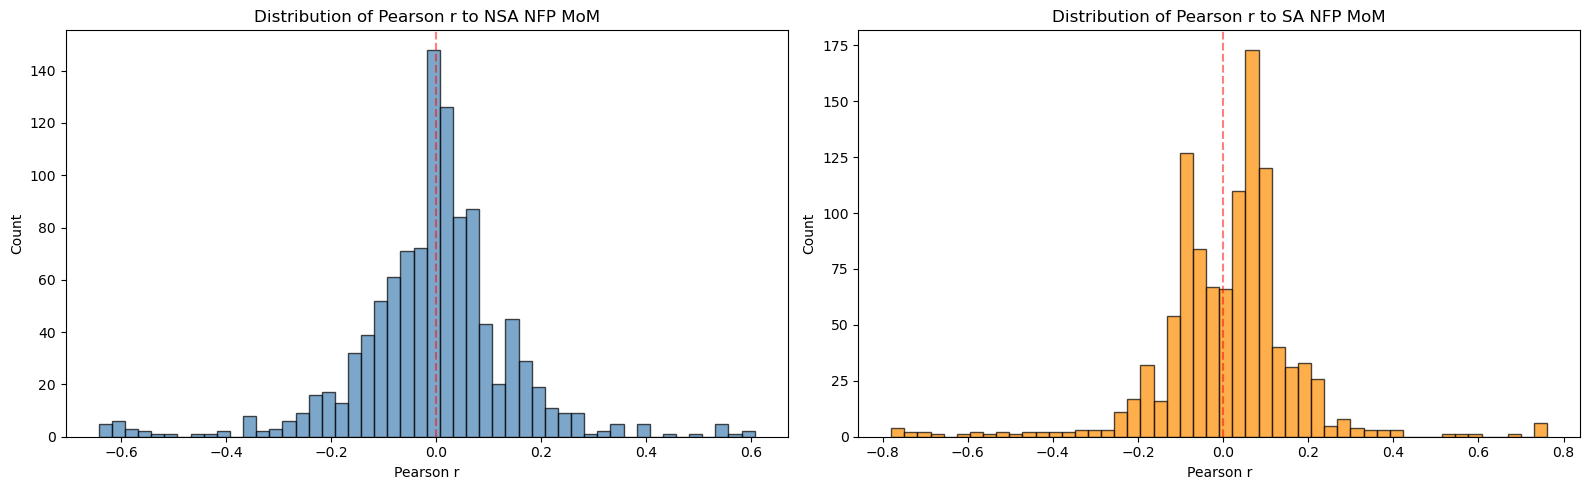

Significant correlations (p < 0.05):
  To NSA MoM: 345/1106 (31.2%)
  To SA MoM: 304/1106 (27.5%)


In [11]:
# Distribution of correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(corr_nsa['pearson_r'].dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('Distribution of Pearson r to NSA NFP MoM')
axes[0].set_xlabel('Pearson r')
axes[0].set_ylabel('Count')

axes[1].hist(corr_sa['pearson_r'].dropna(), bins=50, alpha=0.7, color='darkorange', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Distribution of Pearson r to SA NFP MoM')
axes[1].set_xlabel('Pearson r')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('correlation_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# How many are statistically significant?
sig_nsa = (corr_nsa['pearson_p'] < 0.05).sum()
sig_sa = (corr_sa['pearson_p'] < 0.05).sum()
print(f'Significant correlations (p < 0.05):')
print(f'  To NSA MoM: {sig_nsa}/{len(corr_nsa)} ({sig_nsa/len(corr_nsa)*100:.1f}%)')
print(f'  To SA MoM: {sig_sa}/{len(corr_sa)} ({sig_sa/len(corr_sa)*100:.1f}%)')

---
## 5. Inter-Series Correlation & VIF Analysis

In [12]:
# For VIF, we need to work with the wide format aligned to monthly frequency
# Only use original (non-symlog) series for VIF since symlog duplicates them
orig_cols = [c for c in wide.columns if not c.endswith('_symlog')]

# Resample to monthly and take last value
monthly_wide = wide[orig_cols].resample('MS').last()

# Drop columns with >50% NaN (too sparse for VIF)
thresh = len(monthly_wide) * 0.5
monthly_clean = monthly_wide.dropna(axis=1, thresh=int(thresh))
print(f'Columns after >50% NaN filter: {monthly_clean.shape[1]} (dropped {len(orig_cols) - monthly_clean.shape[1]})')

# Forward fill remaining NaN then drop any remaining
monthly_clean = monthly_clean.ffill().dropna()
print(f'Rows after cleanup: {len(monthly_clean)}')
print(f'Final shape for VIF: {monthly_clean.shape}')

Columns after >50% NaN filter: 61 (dropped 492)
Rows after cleanup: 706
Final shape for VIF: (706, 61)


In [13]:
# Compute VIF for all features
# VIF > 10 indicates problematic multicollinearity
# VIF > 5 is concerning
# We cap computation time by using a subset if too many features

from numpy.linalg import LinAlgError

def compute_vif_safe(df, max_features=200):
    """Compute VIF with fallback for singular matrices."""
    cols = list(df.columns)
    if len(cols) > max_features:
        print(f'  Too many features ({len(cols)}), sampling {max_features} for VIF')
        # Prioritize by variance (keep most informative)
        variances = df.var().sort_values(ascending=False)
        cols = list(variances.head(max_features).index)
        df = df[cols]
    
    # Standardize for numerical stability
    df_std = (df - df.mean()) / df.std()
    df_std = df_std.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    
    # Drop zero-variance columns
    df_std = df_std.loc[:, df_std.std() > 1e-10]
    
    vif_data = []
    X = df_std.values
    
    for i in range(X.shape[1]):
        try:
            vif = variance_inflation_factor(X, i)
        except (LinAlgError, ZeroDivisionError):
            vif = np.inf
        vif_data.append({
            'series_name': df_std.columns[i],
            'VIF': vif
        })
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print('Computing VIF (this may take a minute)...')
vif_df = compute_vif_safe(monthly_clean)
print(f'\nVIF computed for {len(vif_df)} features')
print(f'VIF > 100 (extreme): {(vif_df["VIF"] > 100).sum()}')
print(f'VIF > 10 (problematic): {(vif_df["VIF"] > 10).sum()}')
print(f'VIF > 5 (concerning): {(vif_df["VIF"] > 5).sum()}')
print(f'VIF < 5 (acceptable): {(vif_df["VIF"] < 5).sum()}')

print('\n=== TOP 30 HIGHEST VIF (most collinear) ===')
print(vif_df.head(30).to_string(index=False))

print('\n=== LOWEST VIF (least collinear, most independent) ===')
print(vif_df.tail(20).to_string(index=False))

Computing VIF (this may take a minute)...

VIF computed for 60 features
VIF > 100 (extreme): 54
VIF > 10 (problematic): 55
VIF > 5 (concerning): 55
VIF < 5 (acceptable): 5

=== TOP 30 HIGHEST VIF (most collinear) ===
                                     series_name          VIF
     AWH_Manufacturing_symlog_pct_chg_zscore_12m 3.145209e+09
        AWH_Manufacturing_symlog_diff_zscore_12m 3.135142e+09
            AWH_Manufacturing_pct_chg_zscore_12m 2.185496e+08
               AWH_Manufacturing_diff_zscore_12m 2.158395e+08
     Industrial_Production_symlog_diff_zscore_3m 2.111050e+07
  Industrial_Production_symlog_pct_chg_zscore_3m 1.956487e+07
    Industrial_Production_symlog_diff_zscore_12m 7.457417e+06
 Industrial_Production_symlog_pct_chg_zscore_12m 7.131058e+06
      AWH_Manufacturing_symlog_pct_chg_zscore_3m 2.260929e+06
         AWH_Manufacturing_symlog_diff_zscore_3m 1.788491e+06
         Industrial_Production_pct_chg_zscore_3m 1.600135e+06
            Industrial_Production_diff_

---
## 6. Cross-Correlation Matrix Between Sources

In [14]:
# Identify data source for each series
def classify_source(name):
    """Classify series by its data source."""
    name_lower = name.lower()
    
    # FRED financial/macro indicators
    fred_prefixes = ['credit_spreads', 'yield_curve', 'oil_prices', 'vix', 'sp500',
                     'financial_stress', 'weekly_econ_index', 'ccnsa', 'ccsa']
    for p in fred_prefixes:
        if name_lower.startswith(p):
            return 'FRED_Exog'
    
    # Unifier indicators
    unifier_prefixes = ['challenger', 'ism_', 'cb_consumer', 'awh_', 'ahe_',
                        'housing_starts', 'retail_sales', 'empire_state',
                        'umich_', 'industrial_production']
    for p in unifier_prefixes:
        if name_lower.startswith(p):
            return 'Unifier'
    
    # NOAA
    if 'noaa' in name_lower:
        return 'NOAA'
    
    # ADP
    if name_lower.startswith('adp') or 'adp' in name_lower.split('_'):
        return 'ADP'
    
    # Prosper (typically have long names with survey questions)
    prosper_keywords = ['employed', 'unemployed', 'laid off', 'layoff', 'spending',
                        'consumer mood', 'prosper', 'employment environment',
                        'which of the following', 'looking ahead']
    for kw in prosper_keywords:
        if kw in name_lower:
            return 'Prosper'
    
    return 'Unknown'

# Classify all original series
source_map = {s: classify_source(s) for s in original_series}
source_counts = pd.Series(source_map).value_counts()
print('Series count by source:')
print(source_counts)

# Show unknown series for manual inspection
unknowns = [s for s, src in source_map.items() if src == 'Unknown']
if unknowns:
    print(f'\nUnknown source series ({len(unknowns)}):')
    for s in unknowns:
        print(f'  {s}')

Series count by source:
FRED_Exog    230
Prosper      185
Unifier      131
Unknown        4
NOAA           2
ADP            1
Name: count, dtype: int64

Unknown source series (4):
  Oil_worst_day_pct_diff_zscore_3m
  Oil_worst_day_pct_pct_chg_zscore_3m
  Oil_worst_day_pct_symlog_diff_zscore_3m
  Oil_worst_day_pct_symlog_pct_chg_zscore_3m


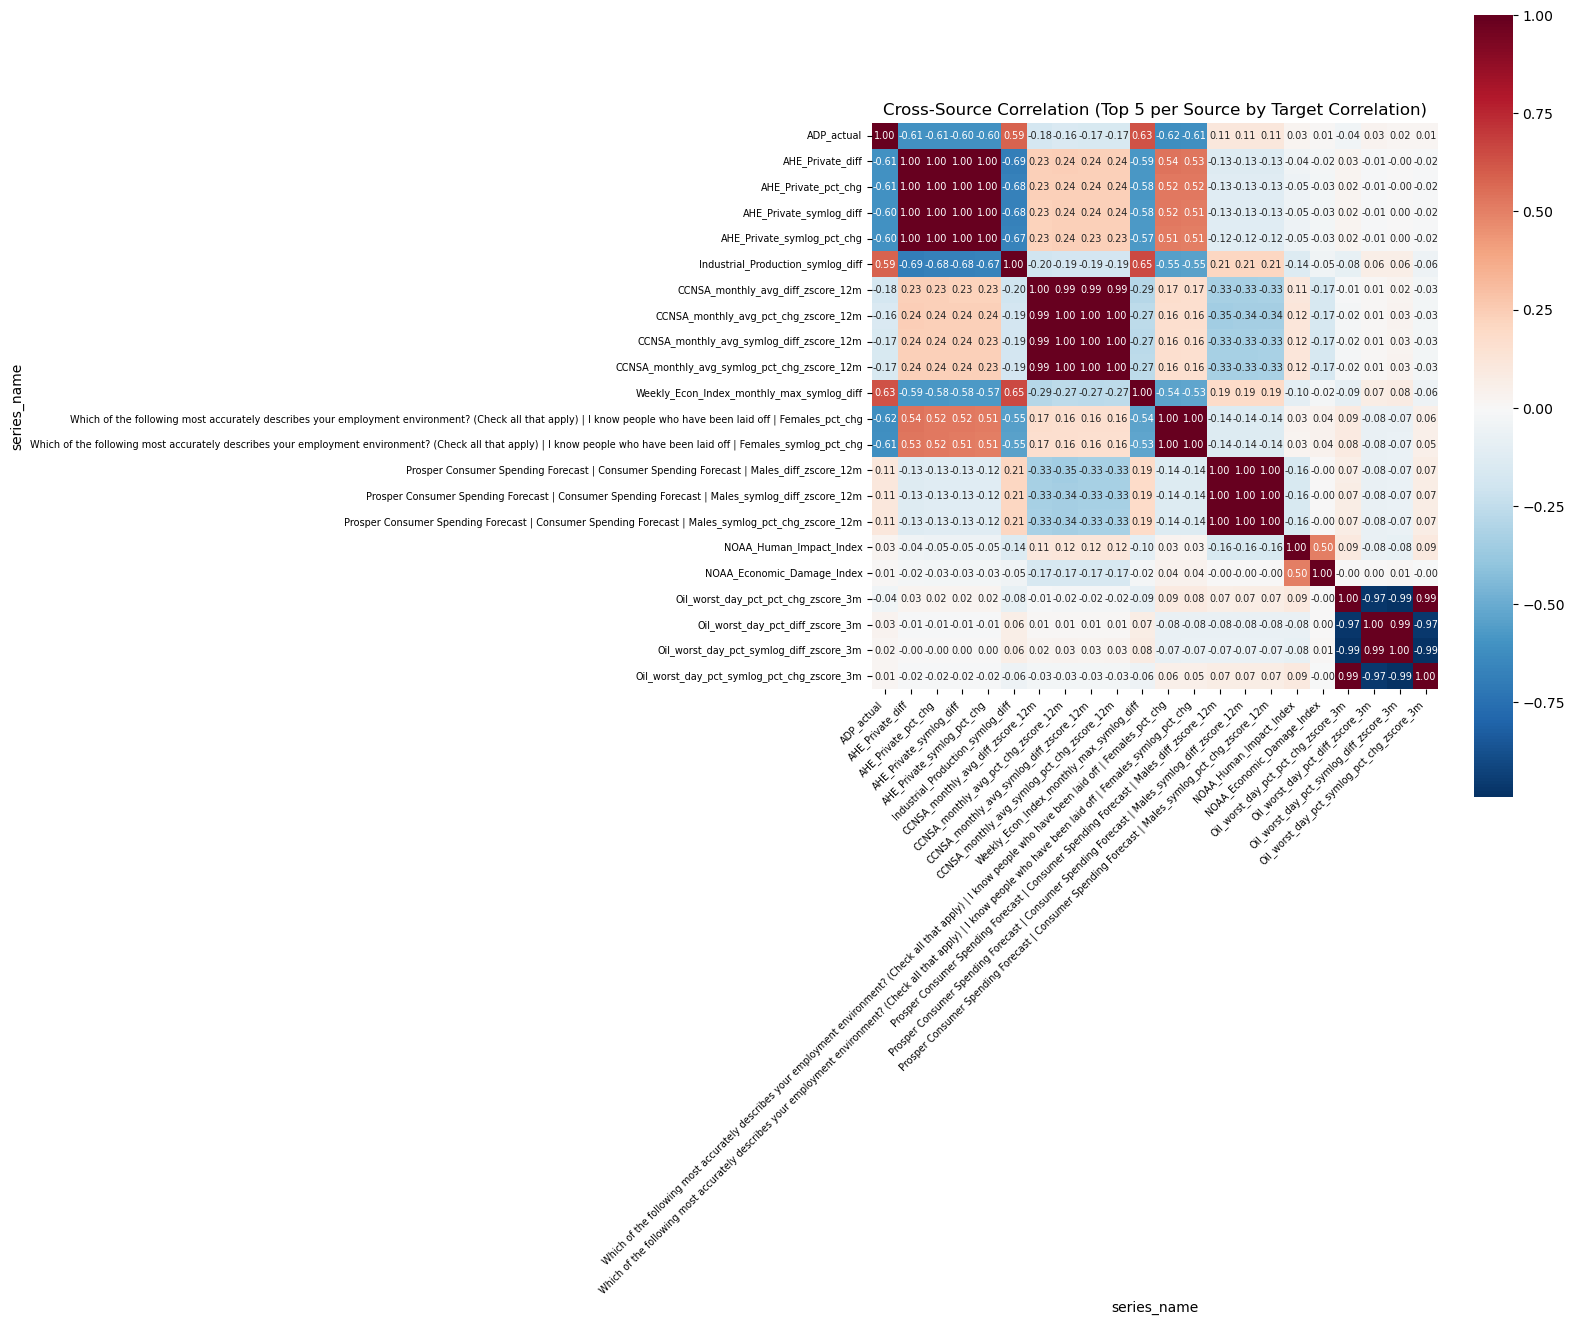

In [15]:
# Inter-source correlation heatmap
# Pick representative series from each source and show cross-correlations

def get_top_by_source(source_map, corr_df, n=5):
    """Get top N most-correlated-to-target series per source."""
    result = {}
    for series, source in source_map.items():
        if series in corr_df.index:
            result[series] = {'source': source, 'abs_corr': float(corr_df.loc[series, 'abs_pearson'])}
    
    df = pd.DataFrame(result).T
    if df.empty:
        return []
    
    df['abs_corr'] = df['abs_corr'].astype(float)
    
    top_series = []
    for source in df['source'].unique():
        source_df = df[df['source'] == source].nlargest(n, 'abs_corr')
        top_series.extend(source_df.index.tolist())
    return top_series

top_per_source = get_top_by_source(source_map, corr_nsa, n=5)
if len(top_per_source) > 0:
    # Get their monthly data
    valid_cols = [c for c in top_per_source if c in monthly_wide.columns]
    top_monthly = monthly_wide[valid_cols].dropna(how='all')
    cross_corr = top_monthly.corr()
    
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(cross_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, ax=ax, annot_kws={'size': 7})
    ax.set_title('Cross-Source Correlation (Top 5 per Source by Target Correlation)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    plt.savefig('cross_source_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Not enough common series for cross-source correlation')

---
## 7. Comprehensive Master Table: Every Series Analyzed

In [16]:
# Build the master analysis table
# Start with stats
master = stats_df[~stats_df['is_symlog']].copy()
master = master.set_index('series_name')

# Add source classification
master['source'] = master.index.map(source_map)

# Add correlations to NSA target
if not corr_nsa.empty:
    corr_nsa_orig = corr_nsa[~corr_nsa.index.str.endswith('_symlog')]
    master = master.join(corr_nsa_orig[['pearson_r', 'spearman_r', 'abs_pearson']].rename(
        columns={'pearson_r': 'corr_nsa_pearson', 'spearman_r': 'corr_nsa_spearman', 'abs_pearson': 'corr_nsa_abs'}
    ), how='left')

# Add correlations to SA target
if not corr_sa.empty:
    corr_sa_orig = corr_sa[~corr_sa.index.str.endswith('_symlog')]
    master = master.join(corr_sa_orig[['pearson_r', 'spearman_r', 'abs_pearson']].rename(
        columns={'pearson_r': 'corr_sa_pearson', 'spearman_r': 'corr_sa_spearman', 'abs_pearson': 'corr_sa_abs'}
    ), how='left')

# Add VIF
if not vif_df.empty:
    vif_indexed = vif_df.set_index('series_name')
    master = master.join(vif_indexed[['VIF']], how='left')

# Add symlog comparison
if not comparison.empty:
    comp_indexed = comparison.set_index('base_name')[['skew_improvement', 'kurt_improvement', 'symlog_recommended', 'both_useful']]
    master = master.join(comp_indexed, how='left')

print(f'Master table: {master.shape}')
master.head()

Master table: (553, 34)


,is_symlog,n_observations,pct_available,mean,std,variance,min,q25,median,q75,max,range,iqr,skewness,kurtosis,abs_skewness,cv,zero_pct,near_zero_pct,jb_stat,jb_pvalue,is_normal,source,corr_nsa_pearson,corr_nsa_spearman,corr_nsa_abs,corr_sa_pearson,corr_sa_spearman,corr_sa_abs,VIF,skew_improvement,kurt_improvement,symlog_recommended,both_useful
series_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ADP_actual,False,191,14.863813,1.450471e+05,556135.228613,3.092864e+11,-6.094000e+06,101000.000000,166000.000000,246000.000000,1.247000e+06,7.341000e+06,145000.000000,-8.584718,90.549801,8.584718,3.834169,0.000000,0.000000,64170.536920,0.000000,False,ADP,0.607627,0.050651,0.607627,0.761584,0.274240,0.761584,NaN,5.590632,83.248226,True,False
AHE_Private,False,236,18.365759,1.064153e+01,0.442751,1.960283e-01,9.870000e+00,10.287500,10.645000,11.022500,1.173000e+01,1.860000e+00,0.735000,0.232813,-1.167156,0.232813,0.041606,0.000000,0.000000,15.517239,0.000427,False,Unifier,-0.037978,0.125076,0.037978,-0.042748,0.312693,0.042748,NaN,0.044151,-0.027381,False,False
AHE_Private_diff,False,235,18.287938,5.531915e-03,0.053566,2.869267e-03,-1.900000e-01,-0.010000,0.000000,0.020000,5.900000e-01,7.800000e-01,0.030000,5.699762,61.983484,5.699762,9.683002,14.468085,14.468085,37270.635260,0.000000,False,Unifier,-0.633664,-0.157933,0.633664,-0.779647,-0.173631,0.779647,NaN,1.491792,20.357657,True,False
AHE_Private_diff_zscore_12m,False,230,17.898833,1.923960e-02,0.986478,9.731386e-01,-2.415952e+00,-0.599935,-0.056406,0.693964,3.088600e+00,5.504551e+00,1.293898,0.204297,0.222527,0.204297,51.273296,0.000000,0.434783,1.931432,0.380711,True,Unifier,-0.232892,-0.151344,0.232892,-0.247167,-0.121431,0.247167,NaN,0.118046,-0.719196,False,False
AHE_Private_diff_zscore_3m,False,234,18.210117,-inf,NaN,NaN,-inf,-0.755929,0.000000,0.872872,1.154701e+00,inf,1.628801,NaN,NaN,NaN,NaN,2.991453,5.128205,NaN,NaN,False,Unifier,NaN,-0.040523,NaN,NaN,-0.092863,NaN,NaN,NaN,NaN,False,False


In [17]:
# ================================================================
# FUNDAMENTAL IMPORTANCE CLASSIFICATION
# Domain knowledge about what each series is and why it matters
# ================================================================

FUNDAMENTAL_IMPORTANCE = {
    # === FRED EXOGENOUS: Financial & Macro ===
    # CCSA/CCNSA: Initial Unemployment Claims - CRITICAL leading indicator
    # People filing for unemployment is directly inverse to NFP
    'CCSA': 'CRITICAL',
    'CCNSA': 'CRITICAL',
    
    # VIX: Fear gauge - captures market stress that precedes hiring freezes
    'VIX': 'HIGH',
    
    # SP500: Wealth effect, business confidence, forward-looking
    'SP500': 'HIGH',
    
    # Credit Spreads: Tightening = harder to borrow = less hiring
    'Credit_Spreads': 'HIGH',
    
    # Yield Curve: Classic recession predictor (12-month lead)
    'Yield_Curve': 'HIGH',
    
    # Oil Prices: Input cost, affects transportation/manufacturing employment
    'Oil_Prices': 'MEDIUM',
    
    # Financial Stress Index: Composite stress measure
    'Financial_Stress': 'MEDIUM',
    
    # Weekly Economic Index: Real-time GDP proxy
    'Weekly_Econ_Index': 'HIGH',
    
    # === UNIFIER: Economic Indicators ===
    # ADP: Private payroll estimate - basically a direct NFP predictor
    'ADP': 'CRITICAL',
    
    # ISM Manufacturing PMI: Employment component is a leading indicator
    'ISM_Manufacturing_Index': 'HIGH',
    'ISM_NonManufacturing_Index': 'HIGH',
    
    # Consumer Confidence: Spending intentions -> demand -> hiring
    'CB_Consumer_Confidence': 'MEDIUM',
    
    # Average Weekly Hours: HOURS ARE CUT BEFORE HEADCOUNT
    # This is one of the most important leading indicators
    'AWH_All_Private': 'CRITICAL',
    'AWH_Manufacturing': 'HIGH',
    
    # Average Hourly Earnings: Wage pressure -> hiring costs
    'AHE_Private': 'MEDIUM',
    
    # Challenger Job Cuts: Direct layoff announcements
    'Challenger_Job_Cuts': 'HIGH',
    
    # Housing Starts: Construction employment, wealth effect
    'Housing_Starts': 'MEDIUM',
    
    # Retail Sales: Consumer demand -> service sector hiring
    'Retail_Sales': 'MEDIUM',
    
    # Empire State Mfg: Regional PMI, noisy but informative
    'Empire_State_Mfg': 'LOW',
    
    # UMich Consumer Expectations: Forward-looking sentiment
    'UMich_Expectations': 'LOW',
    
    # Industrial Production: Factory output -> manufacturing jobs
    'Industrial_Production': 'MEDIUM',
    
    # === NOAA ===
    # Weather disasters: Can cause temporary employment disruptions
    # but relationship is noisy and transient
    'NOAA': 'LOW',
    
    # === PROSPER ===
    # Survey data: sentiment-based, can capture turning points
    # but noisy and short history
    'Prosper': 'LOW_MEDIUM',
}

def get_fundamental_importance(series_name):
    """Get fundamental importance rating for a series."""
    name_lower = series_name.lower()
    
    # Check exact prefix matches
    for key, importance in FUNDAMENTAL_IMPORTANCE.items():
        if name_lower.startswith(key.lower()):
            return importance
    
    # Check contains for broader matching
    if 'noaa' in name_lower:
        return 'LOW'
    if any(kw in name_lower for kw in ['employed', 'unemployed', 'layoff', 'laid off', 'spending', 'consumer mood']):
        return 'LOW_MEDIUM'  # Prosper
    
    return 'UNKNOWN'

master['fundamental_importance'] = master.index.map(get_fundamental_importance)

print('Fundamental importance distribution:')
print(master['fundamental_importance'].value_counts())

Fundamental importance distribution:
fundamental_importance
HIGH          209
LOW_MEDIUM    185
MEDIUM         98
CRITICAL       33
LOW            24
UNKNOWN         4
Name: count, dtype: int64


In [18]:
# ================================================================
# TRANSFORM RECOMMENDATION
# Which series are better raw, symlog, or both?
# ================================================================

def recommend_transform(row):
    """Recommend raw vs symlog vs both based on distributional properties."""
    abs_skew = abs(row.get('skewness', 0))
    abs_kurt = abs(row.get('kurtosis', 0))
    skew_imp = row.get('skew_improvement', 0)
    kurt_imp = row.get('kurt_improvement', 0)
    
    # If raw is already well-behaved (low skew + low kurtosis)
    if abs_skew < 1.0 and abs_kurt < 3.0:
        if pd.notna(skew_imp) and (skew_imp > 0.3 or kurt_imp > 1.0):
            return 'BOTH'  # Raw is fine but symlog also adds value
        return 'RAW_ONLY'
    
    # If very skewed or heavy-tailed
    if abs_skew > 3.0 or abs_kurt > 10.0:
        if pd.notna(kurt_imp) and kurt_imp > 2.0:
            return 'SYMLOG_PREFERRED'  # Symlog significantly better
        return 'BOTH'  # Both capture different aspects
    
    # Moderate skew/kurtosis
    if pd.notna(skew_imp) and skew_imp > 0.5:
        return 'SYMLOG_PREFERRED'
    if pd.notna(kurt_imp) and kurt_imp > 2.0:
        return 'SYMLOG_PREFERRED'
    
    return 'BOTH'

master['transform_recommendation'] = master.apply(recommend_transform, axis=1)

print('Transform recommendations:')
print(master['transform_recommendation'].value_counts())

Transform recommendations:
transform_recommendation
RAW_ONLY            433
SYMLOG_PREFERRED     60
BOTH                 60
Name: count, dtype: int64


In [19]:
# ================================================================
# FINAL VERDICT: KEEP / DROP / CONDITIONAL for every series
# ================================================================

def final_verdict(row):
    """
    Final keep/drop decision based on all factors.
    
    KEEP: Fundamentally important OR statistically useful (corr + reasonable properties)
    CONDITIONAL: Borderline - keep if model performance improves, otherwise drop
    DROP: Low importance + low correlation + problematic statistics
    """
    importance = row.get('fundamental_importance', 'UNKNOWN')
    corr_nsa = abs(row.get('corr_nsa_abs', 0) or 0)
    corr_sa = abs(row.get('corr_sa_abs', 0) or 0)
    max_corr = max(corr_nsa, corr_sa)
    vif = row.get('VIF', np.nan)
    n_obs = row.get('n_observations', 0)
    abs_skew = abs(row.get('skewness', 0))
    abs_kurt = abs(row.get('kurtosis', 0))
    std = row.get('std', 0)
    pct_avail = row.get('pct_available', 0)
    
    reasons = []
    
    # --- AUTOMATIC KEEP ---
    if importance == 'CRITICAL':
        reasons.append(f'CRITICAL domain importance')
        return 'KEEP', '; '.join(reasons)
    
    # --- AUTOMATIC DROP ---
    # Near-zero variance (constant)
    if std < 1e-6:
        return 'DROP', 'Zero/near-zero variance (constant)'
    
    # Too few observations
    if n_obs < 24:  # Less than 2 years
        if importance not in ('CRITICAL', 'HIGH'):
            return 'DROP', f'Too few observations ({n_obs} < 24)'
    
    # --- SCORING ---
    score = 0
    
    # Correlation contribution (0-40 points)
    if max_corr > 0.3:
        score += 40
        reasons.append(f'Strong corr ({max_corr:.3f})')
    elif max_corr > 0.15:
        score += 25
        reasons.append(f'Moderate corr ({max_corr:.3f})')
    elif max_corr > 0.08:
        score += 10
        reasons.append(f'Weak corr ({max_corr:.3f})')
    else:
        reasons.append(f'Very weak corr ({max_corr:.3f})')
    
    # Fundamental importance (0-30 points)
    imp_scores = {'HIGH': 30, 'MEDIUM': 20, 'LOW_MEDIUM': 10, 'LOW': 5, 'UNKNOWN': 0}
    score += imp_scores.get(importance, 0)
    
    # Data availability (0-15 points)
    if pct_avail > 80:
        score += 15
    elif pct_avail > 50:
        score += 10
    elif pct_avail > 30:
        score += 5
    
    # Distributional quality (0-15 points)
    if abs_skew < 2 and abs_kurt < 7:
        score += 15
    elif abs_skew < 5 and abs_kurt < 20:
        score += 8
    else:
        reasons.append(f'Poor distribution (skew={row["skewness"]:.1f}, kurt={row["kurtosis"]:.1f})')
    
    # VIF penalty
    if pd.notna(vif) and vif > 100:
        score -= 15
        reasons.append(f'Extreme VIF ({vif:.0f})')
    elif pd.notna(vif) and vif > 10:
        score -= 5
        reasons.append(f'High VIF ({vif:.0f})')
    
    # Final decision
    if score >= 50:
        return 'KEEP', '; '.join(reasons)
    elif score >= 25:
        return 'CONDITIONAL', '; '.join(reasons)
    else:
        return 'DROP', '; '.join(reasons)

verdicts = master.apply(final_verdict, axis=1, result_type='expand')
master['verdict'] = verdicts[0]
master['verdict_reason'] = verdicts[1]

print('=== FINAL VERDICT DISTRIBUTION ===')
print(master['verdict'].value_counts())
print(f'\nTotal original series: {len(master)}')

=== FINAL VERDICT DISTRIBUTION ===
verdict
KEEP           289
CONDITIONAL    243
DROP            21
Name: count, dtype: int64

Total original series: 553


In [20]:
# Show verdict breakdown by source
print('=== VERDICT BY SOURCE ===')
verdict_by_source = master.groupby(['source', 'verdict']).size().unstack(fill_value=0)
print(verdict_by_source)

print('\n=== VERDICT BY FUNDAMENTAL IMPORTANCE ===')
verdict_by_imp = master.groupby(['fundamental_importance', 'verdict']).size().unstack(fill_value=0)
print(verdict_by_imp)

=== VERDICT BY SOURCE ===
verdict    CONDITIONAL  DROP  KEEP
source                            
ADP                  0     0     1
FRED_Exog           70     0   160
NOAA                 1     0     1
Prosper            132     0    53
Unifier             40    17    74
Unknown              0     4     0

=== VERDICT BY FUNDAMENTAL IMPORTANCE ===
verdict                 CONDITIONAL  DROP  KEEP
fundamental_importance                         
CRITICAL                          0     0    33
HIGH                             49     0   160
LOW                               6    16     2
LOW_MEDIUM                      132     0    53
MEDIUM                           56     1    41
UNKNOWN                           0     4     0


---
## 8. Detailed Series-by-Series Report

In [21]:
# === KEEP SERIES ===
keep_series = master[master['verdict'] == 'KEEP'].sort_values('corr_nsa_abs', ascending=False)
print(f'\n{"="*80}')
print(f'KEEP SERIES ({len(keep_series)} series)')
print(f'{"="*80}')

display_cols = ['source', 'fundamental_importance', 'n_observations', 'mean', 'std', 
                'skewness', 'kurtosis', 'corr_nsa_abs', 'corr_sa_abs', 
                'VIF', 'transform_recommendation', 'verdict_reason']
available_cols = [c for c in display_cols if c in keep_series.columns]

for idx, row in keep_series.iterrows():
    print(f'\n--- {idx} ---')
    for col in available_cols:
        val = row.get(col, 'N/A')
        if isinstance(val, float):
            print(f'  {col:30s}: {val:.4f}')
        else:
            print(f'  {col:30s}: {val}')


KEEP SERIES (289 series)

--- CCNSA_monthly_avg_diff_zscore_12m ---
  source                        : FRED_Exog
  fundamental_importance        : CRITICAL
  n_observations                : 423
  mean                          : 0.0441
  std                           : 0.9586
  skewness                      : 0.7289
  kurtosis                      : -0.2406
  corr_nsa_abs                  : 0.6431
  corr_sa_abs                   : 0.1635
  VIF                           : nan
  transform_recommendation      : RAW_ONLY
  verdict_reason                : CRITICAL domain importance

--- AHE_Private_diff ---
  source                        : Unifier
  fundamental_importance        : MEDIUM
  n_observations                : 235
  mean                          : 0.0055
  std                           : 0.0536
  skewness                      : 5.6998
  kurtosis                      : 61.9835
  corr_nsa_abs                  : 0.6337
  corr_sa_abs                   : 0.7796
  VIF                  

In [22]:
# === CONDITIONAL SERIES ===
cond_series = master[master['verdict'] == 'CONDITIONAL'].sort_values('corr_nsa_abs', ascending=False)
print(f'\n{"="*80}')
print(f'CONDITIONAL SERIES ({len(cond_series)} series) - Keep if model improves, otherwise drop')
print(f'{"="*80}')

for idx, row in cond_series.iterrows():
    print(f'\n--- {idx} ---')
    for col in available_cols:
        val = row.get(col, 'N/A')
        if isinstance(val, float):
            print(f'  {col:30s}: {val:.4f}')
        else:
            print(f'  {col:30s}: {val}')


CONDITIONAL SERIES (243 series) - Keep if model improves, otherwise drop

--- Empire_State_Mfg_diff ---
  source                        : Unifier
  fundamental_importance        : LOW
  n_observations                : 293
  mean                          : 0.0321
  std                           : 13.6122
  skewness                      : -0.1246
  kurtosis                      : 2.1907
  corr_nsa_abs                  : 0.2806
  corr_sa_abs                   : 0.2884
  VIF                           : nan
  transform_recommendation      : RAW_ONLY
  verdict_reason                : Moderate corr (0.288)

--- Empire_State_Mfg_diff_zscore_12m ---
  source                        : Unifier
  fundamental_importance        : LOW
  n_observations                : 288
  mean                          : -0.0130
  std                           : 0.9592
  skewness                      : -0.1098
  kurtosis                      : -0.3448
  corr_nsa_abs                  : 0.1693
  corr_sa_abs           

In [23]:
# === DROP SERIES ===
drop_series = master[master['verdict'] == 'DROP'].sort_values('corr_nsa_abs', ascending=False)
print(f'\n{"="*80}')
print(f'DROP SERIES ({len(drop_series)} series) - Recommended for removal')
print(f'{"="*80}')

for idx, row in drop_series.iterrows():
    print(f'\n--- {idx} ---')
    for col in available_cols:
        val = row.get(col, 'N/A')
        if isinstance(val, float):
            print(f'  {col:30s}: {val:.4f}')
        else:
            print(f'  {col:30s}: {val}')


DROP SERIES (21 series) - Recommended for removal

--- Empire_State_Mfg_pct_chg_zscore_3m ---
  source                        : Unifier
  fundamental_importance        : LOW
  n_observations                : 292
  mean                          : -0.0565
  std                           : 0.8219
  skewness                      : 0.1598
  kurtosis                      : -1.5143
  corr_nsa_abs                  : 0.0609
  corr_sa_abs                   : 0.0687
  VIF                           : nan
  transform_recommendation      : RAW_ONLY
  verdict_reason                : Very weak corr (0.069)

--- Empire_State_Mfg_symlog_diff ---
  source                        : Unifier
  fundamental_importance        : LOW
  n_observations                : 293
  mean                          : 0.0037
  std                           : 2.0947
  skewness                      : -0.1238
  kurtosis                      : 1.5066
  corr_nsa_abs                  : 0.0572
  corr_sa_abs                   : 0.071

---
## 9. Transformation Analysis: Raw vs SymLog Detailed Comparison

In [24]:
# Compare symlog vs raw correlations to target for each series
# This tells us if symlog actually improves predictive power

symlog_corr_comparison = []

for series in original_series:
    symlog_name = f'{series}_symlog'
    
    raw_corr_nsa = corr_nsa.loc[series, 'abs_pearson'] if series in corr_nsa.index else np.nan
    sym_corr_nsa = corr_nsa.loc[symlog_name, 'abs_pearson'] if symlog_name in corr_nsa.index else np.nan
    raw_corr_sa = corr_sa.loc[series, 'abs_pearson'] if series in corr_sa.index else np.nan
    sym_corr_sa = corr_sa.loc[symlog_name, 'abs_pearson'] if symlog_name in corr_sa.index else np.nan
    
    symlog_corr_comparison.append({
        'series': series,
        'source': source_map.get(series, 'Unknown'),
        'raw_corr_nsa': raw_corr_nsa,
        'symlog_corr_nsa': sym_corr_nsa,
        'corr_nsa_diff': (sym_corr_nsa or 0) - (raw_corr_nsa or 0),
        'raw_corr_sa': raw_corr_sa,
        'symlog_corr_sa': sym_corr_sa,
        'corr_sa_diff': (sym_corr_sa or 0) - (raw_corr_sa or 0),
    })

symlog_comp_df = pd.DataFrame(symlog_corr_comparison)
symlog_comp_df['max_diff'] = symlog_comp_df[['corr_nsa_diff', 'corr_sa_diff']].max(axis=1)

print('=== SERIES WHERE SYMLOG IMPROVES TARGET CORRELATION ===')
symlog_better = symlog_comp_df[symlog_comp_df['max_diff'] > 0.01].sort_values('max_diff', ascending=False)
print(f'{len(symlog_better)} series where symlog improves correlation by >0.01')
print(symlog_better.head(30).to_string(index=False))

print('\n=== SERIES WHERE RAW HAS BETTER TARGET CORRELATION ===')
raw_better = symlog_comp_df[symlog_comp_df['max_diff'] < -0.01].sort_values('max_diff')
print(f'{len(raw_better)} series where raw is better by >0.01')
print(raw_better.head(30).to_string(index=False))

=== SERIES WHERE SYMLOG IMPROVES TARGET CORRELATION ===
23 series where symlog improves correlation by >0.01
                                                                                                                                                                                               series    source  raw_corr_nsa  symlog_corr_nsa  corr_nsa_diff  raw_corr_sa  symlog_corr_sa  corr_sa_diff  max_diff
                                                                                                                                                                          Retail_Sales_symlog_pct_chg   Unifier      0.024860         0.185206       0.160346     0.004038        0.224258      0.220220  0.220220
                                                                                                                                                                                 Retail_Sales_pct_chg   Unifier      0.021259         0.123005       0.101746     0.008492        0.1

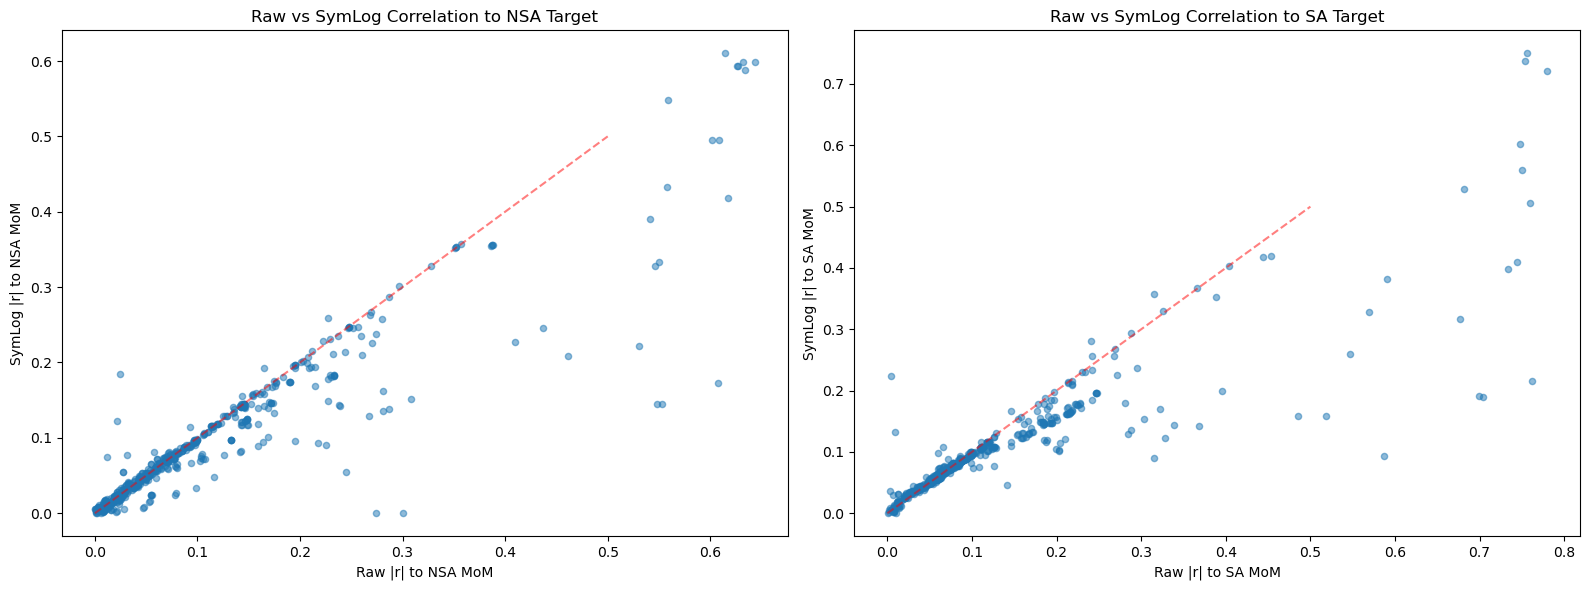

In [25]:
# Scatter plot: raw vs symlog correlation improvement
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

valid = symlog_comp_df.dropna(subset=['raw_corr_nsa', 'symlog_corr_nsa'])
axes[0].scatter(valid['raw_corr_nsa'], valid['symlog_corr_nsa'], alpha=0.5, s=20)
axes[0].plot([0, 0.5], [0, 0.5], 'r--', alpha=0.5)
axes[0].set_xlabel('Raw |r| to NSA MoM')
axes[0].set_ylabel('SymLog |r| to NSA MoM')
axes[0].set_title('Raw vs SymLog Correlation to NSA Target')

valid_sa = symlog_comp_df.dropna(subset=['raw_corr_sa', 'symlog_corr_sa'])
axes[1].scatter(valid_sa['raw_corr_sa'], valid_sa['symlog_corr_sa'], alpha=0.5, s=20)
axes[1].plot([0, 0.5], [0, 0.5], 'r--', alpha=0.5)
axes[1].set_xlabel('Raw |r| to SA MoM')
axes[1].set_ylabel('SymLog |r| to SA MoM')
axes[1].set_title('Raw vs SymLog Correlation to SA Target')

plt.tight_layout()
plt.savefig('raw_vs_symlog_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 10. Summary Visualizations

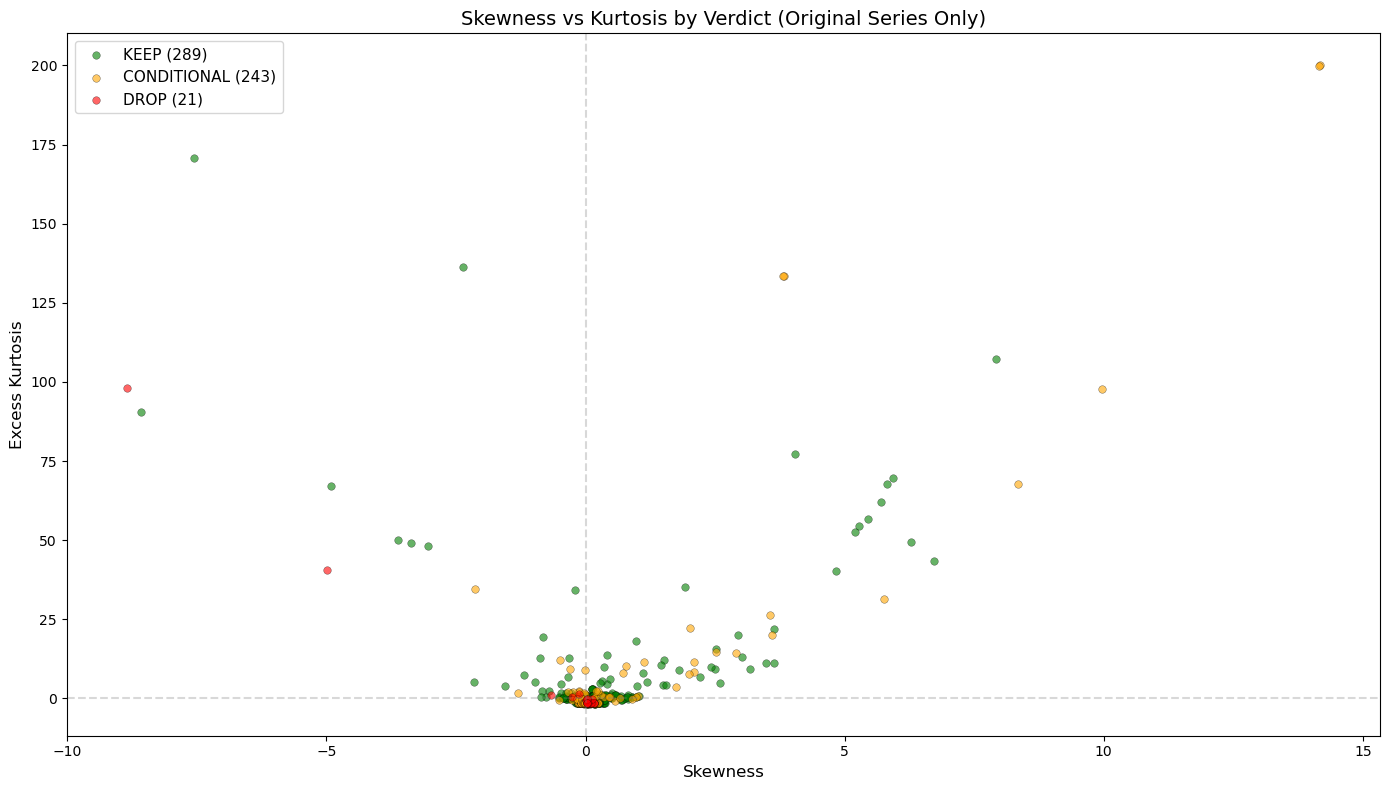

In [26]:
# Scatter: skewness vs kurtosis colored by verdict
fig, ax = plt.subplots(figsize=(14, 8))

colors = {'KEEP': 'green', 'CONDITIONAL': 'orange', 'DROP': 'red'}
for verdict, color in colors.items():
    subset = master[master['verdict'] == verdict]
    ax.scatter(subset['skewness'], subset['kurtosis'], c=color, alpha=0.6, 
               s=30, label=f'{verdict} ({len(subset)})', edgecolors='black', linewidths=0.3)

ax.set_xlabel('Skewness', fontsize=12)
ax.set_ylabel('Excess Kurtosis', fontsize=12)
ax.set_title('Skewness vs Kurtosis by Verdict (Original Series Only)', fontsize=14)
ax.legend(fontsize=11)
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('skewness_vs_kurtosis_by_verdict.png', dpi=150, bbox_inches='tight')
plt.show()

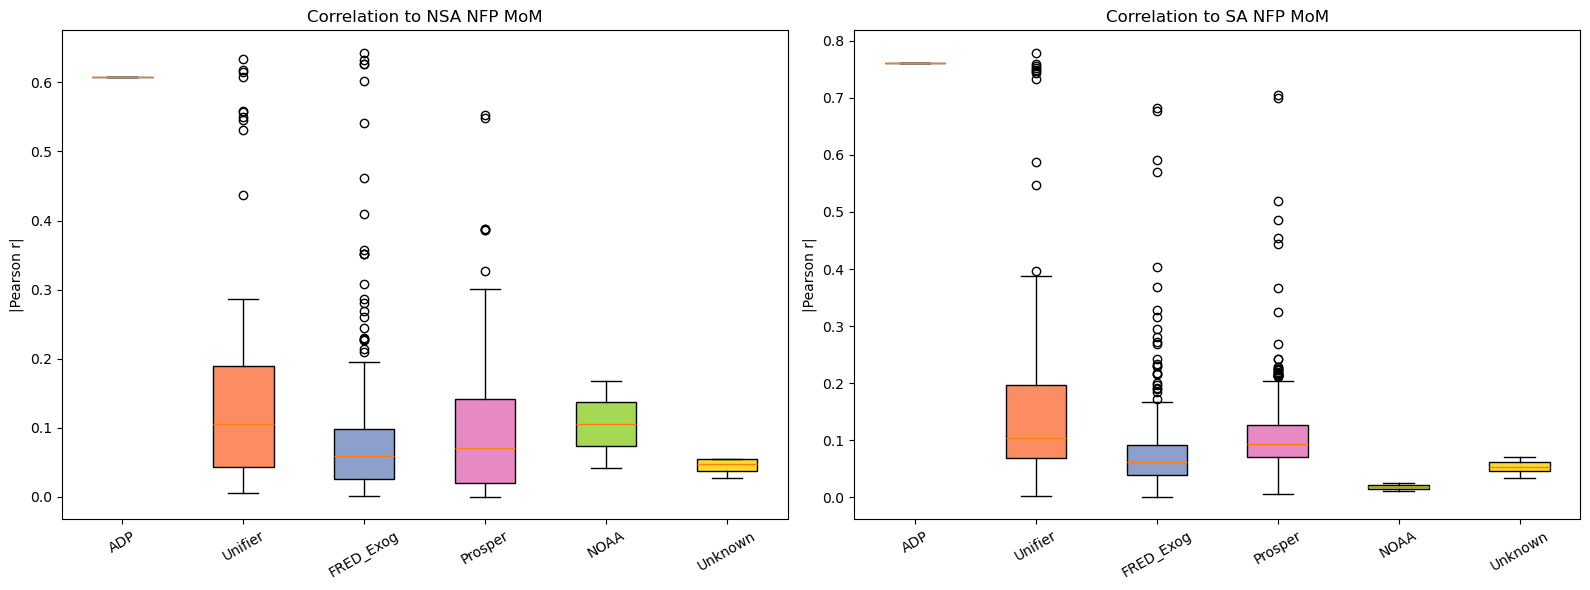

In [27]:
# Correlation to target by source
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, target_col, title in [
    (axes[0], 'corr_nsa_abs', 'Correlation to NSA NFP MoM'),
    (axes[1], 'corr_sa_abs', 'Correlation to SA NFP MoM')
]:
    data = master.dropna(subset=[target_col])
    sources = data['source'].unique()
    
    box_data = [data[data['source'] == s][target_col].values for s in sources]
    bp = ax.boxplot(box_data, labels=sources, patch_artist=True)
    
    palette = sns.color_palette('Set2', len(sources))
    for patch, color in zip(bp['boxes'], palette):
        patch.set_facecolor(color)
    
    ax.set_title(title)
    ax.set_ylabel('|Pearson r|')
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('correlation_by_source.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 11. Export Full Analysis to CSV

In [28]:
# Export the master analysis table
export_cols = [
    'source', 'fundamental_importance', 'verdict', 'verdict_reason',
    'transform_recommendation', 'n_observations', 'pct_available',
    'mean', 'std', 'variance', 'min', 'max', 'range',
    'skewness', 'kurtosis', 'abs_skewness',
    'corr_nsa_pearson', 'corr_nsa_spearman', 'corr_nsa_abs',
    'corr_sa_pearson', 'corr_sa_spearman', 'corr_sa_abs',
    'VIF',
    'skew_improvement', 'kurt_improvement', 'symlog_recommended',
    'jb_stat', 'jb_pvalue', 'is_normal',
    'cv', 'zero_pct'
]
available_export = [c for c in export_cols if c in master.columns]

export_df = master[available_export].copy()
export_df.index.name = 'series_name'
export_df = export_df.sort_values(['verdict', 'source', 'corr_nsa_abs'], ascending=[True, True, False])

export_path = 'master_snapshot_analysis.csv'
export_df.to_csv(export_path)
print(f'Exported to {export_path}')
print(f'Shape: {export_df.shape}')

# Summary
print('\n' + '='*80)
print('FINAL SUMMARY')
print('='*80)
print(f'Total original series analyzed: {len(master)}')
print(f'\nVerdict distribution:')
for v in ['KEEP', 'CONDITIONAL', 'DROP']:
    count = (master['verdict'] == v).sum()
    print(f'  {v}: {count} ({count/len(master)*100:.1f}%)')

print(f'\nTransform recommendations:')
print(master['transform_recommendation'].value_counts().to_string())

print(f'\nBy source:')
print(master.groupby('source')['verdict'].value_counts().unstack(fill_value=0).to_string())

Exported to master_snapshot_analysis.csv
Shape: (553, 31)

FINAL SUMMARY
Total original series analyzed: 553

Verdict distribution:
  KEEP: 289 (52.3%)
  CONDITIONAL: 243 (43.9%)
  DROP: 21 (3.8%)

Transform recommendations:
transform_recommendation
RAW_ONLY            433
SYMLOG_PREFERRED     60
BOTH                 60

By source:
verdict    CONDITIONAL  DROP  KEEP
source                            
ADP                  0     0     1
FRED_Exog           70     0   160
NOAA                 1     0     1
Prosper            132     0    53
Unifier             40    17    74
Unknown              0     4     0


---
## 12. Source-by-Source Deep Dive & Transformation Justification

In [29]:
# ================================================================
# FRED EXOGENOUS DEEP DIVE
# ================================================================
print('='*80)
print('FRED EXOGENOUS SERIES - DEEP DIVE')
print('='*80)

fred_exog = master[master['source'] == 'FRED_Exog'].sort_values('corr_nsa_abs', ascending=False)
print(f'\nTotal FRED Exog series: {len(fred_exog)}')
print(f'Verdict: {fred_exog["verdict"].value_counts().to_dict()}')

# Group by base indicator
def get_base_indicator(name):
    """Extract base indicator from transformation name."""
    parts = name.split('_')
    # Common patterns: CCSA_monthly_avg_diff_zscore_3m -> CCSA
    for prefix in ['CCSA', 'CCNSA', 'VIX', 'SP500', 'Credit_Spreads', 'Yield_Curve',
                    'Oil_Prices', 'Financial_Stress', 'Weekly_Econ_Index']:
        if name.startswith(prefix):
            return prefix
    return parts[0]

fred_exog_copy = fred_exog.copy()
fred_exog_copy['base_indicator'] = fred_exog_copy.index.map(get_base_indicator)

for indicator in fred_exog_copy['base_indicator'].unique():
    subset = fred_exog_copy[fred_exog_copy['base_indicator'] == indicator]
    print(f'\n--- {indicator} ({len(subset)} transformations) ---')
    for idx, row in subset.iterrows():
        corr = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
        skew = f"{row.get('skewness', 0):.2f}" if pd.notna(row.get('skewness')) else 'N/A'
        kurt = f"{row.get('kurtosis', 0):.2f}" if pd.notna(row.get('kurtosis')) else 'N/A'
        print(f'  {row["verdict"]:12s} | {idx:50s} | corr={corr} | skew={skew} | kurt={kurt} | {row.get("transform_recommendation", "N/A")}')

FRED EXOGENOUS SERIES - DEEP DIVE

Total FRED Exog series: 230
Verdict: {'KEEP': 160, 'CONDITIONAL': 70}

--- CCNSA (9 transformations) ---
  KEEP         | CCNSA_monthly_avg_diff_zscore_12m                  | corr=0.643 | skew=0.73 | kurt=-0.24 | RAW_ONLY
  KEEP         | CCNSA_monthly_avg_pct_chg_zscore_12m               | corr=0.632 | skew=0.82 | kurt=-0.24 | RAW_ONLY
  KEEP         | CCNSA_monthly_avg_symlog_diff_zscore_12m           | corr=0.627 | skew=0.69 | kurt=-0.41 | RAW_ONLY
  KEEP         | CCNSA_monthly_avg_symlog_pct_chg_zscore_12m        | corr=0.626 | skew=0.69 | kurt=-0.41 | RAW_ONLY
  KEEP         | CCNSA_max_spike_diff_zscore_3m                     | corr=0.357 | skew=0.09 | kurt=-1.70 | RAW_ONLY
  KEEP         | CCNSA_max_spike_pct_chg_zscore_3m                  | corr=0.352 | skew=0.18 | kurt=-1.68 | RAW_ONLY
  KEEP         | CCNSA_max_spike_symlog_diff_zscore_3m              | corr=0.352 | skew=0.17 | kurt=-1.68 | RAW_ONLY
  KEEP         | CCNSA_max_spike_symlog_p

In [30]:
# ================================================================
# UNIFIER DEEP DIVE
# ================================================================
print('='*80)
print('UNIFIER SERIES - DEEP DIVE')
print('='*80)

unifier = master[master['source'] == 'Unifier'].sort_values('corr_nsa_abs', ascending=False)
print(f'\nTotal Unifier series: {len(unifier)}')
print(f'Verdict: {unifier["verdict"].value_counts().to_dict()}')

def get_unifier_base(name):
    for prefix in ['Challenger_Job_Cuts', 'ISM_Manufacturing_Index', 'ISM_NonManufacturing_Index',
                    'CB_Consumer_Confidence', 'AWH_All_Private', 'AWH_Manufacturing',
                    'AHE_Private', 'Housing_Starts', 'Retail_Sales', 'Empire_State_Mfg',
                    'UMich_Expectations', 'Industrial_Production']:
        if name.startswith(prefix):
            return prefix
    return name.split('_')[0]

unifier_copy = unifier.copy()
unifier_copy['base_indicator'] = unifier_copy.index.map(get_unifier_base)

for indicator in unifier_copy['base_indicator'].unique():
    subset = unifier_copy[unifier_copy['base_indicator'] == indicator]
    print(f'\n--- {indicator} ({len(subset)} transformations) ---')
    for idx, row in subset.iterrows():
        corr = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
        skew = f"{row.get('skewness', 0):.2f}" if pd.notna(row.get('skewness')) else 'N/A'
        kurt = f"{row.get('kurtosis', 0):.2f}" if pd.notna(row.get('kurtosis')) else 'N/A'
        print(f'  {row["verdict"]:12s} | {idx:55s} | corr={corr} | skew={skew} | kurt={kurt} | {row.get("transform_recommendation", "N/A")}')

UNIFIER SERIES - DEEP DIVE

Total Unifier series: 131
Verdict: {'KEEP': 74, 'CONDITIONAL': 40, 'DROP': 17}

--- AHE_Private (13 transformations) ---
  KEEP         | AHE_Private_diff                                        | corr=0.634 | skew=5.70 | kurt=61.98 | SYMLOG_PREFERRED
  KEEP         | AHE_Private_pct_chg                                     | corr=0.618 | skew=5.45 | kurt=56.58 | SYMLOG_PREFERRED
  KEEP         | AHE_Private_symlog_diff                                 | corr=0.615 | skew=5.29 | kurt=54.60 | SYMLOG_PREFERRED
  KEEP         | AHE_Private_symlog_pct_chg                              | corr=0.608 | skew=5.19 | kurt=52.61 | SYMLOG_PREFERRED
  KEEP         | AHE_Private_symlog_diff_zscore_12m                      | corr=0.233 | skew=0.20 | kurt=0.22 | RAW_ONLY
  KEEP         | AHE_Private_diff_zscore_12m                             | corr=0.233 | skew=0.20 | kurt=0.22 | RAW_ONLY
  KEEP         | AHE_Private_symlog_pct_chg_zscore_12m                   | corr=0.233 | s

In [31]:
# ================================================================
# PROSPER DEEP DIVE
# ================================================================
print('='*80)
print('PROSPER SERIES - DEEP DIVE')
print('='*80)

prosper = master[master['source'] == 'Prosper'].sort_values('corr_nsa_abs', ascending=False)
print(f'\nTotal Prosper series: {len(prosper)}')
print(f'Verdict: {prosper["verdict"].value_counts().to_dict()}')

for idx, row in prosper.iterrows():
    corr = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
    skew = f"{row.get('skewness', 0):.2f}" if pd.notna(row.get('skewness')) else 'N/A'
    kurt = f"{row.get('kurtosis', 0):.2f}" if pd.notna(row.get('kurtosis')) else 'N/A'
    n = row.get('n_observations', 0)
    print(f'{row["verdict"]:12s} | n={n:4.0f} | corr={corr} | skew={skew} | kurt={kurt} | {idx}')

PROSPER SERIES - DEEP DIVE

Total Prosper series: 185
Verdict: {'CONDITIONAL': 132, 'KEEP': 53}
KEEP         | n= 288 | corr=0.553 | skew=5.93 | kurt=69.78 | Which of the following most accurately describes your employment environment? (Check all that apply) | I know people who have been laid off | Females_pct_chg
KEEP         | n= 288 | corr=0.548 | skew=5.82 | kurt=67.80 | Which of the following most accurately describes your employment environment? (Check all that apply) | I know people who have been laid off | Females_symlog_pct_chg
KEEP         | n= 269 | corr=0.388 | skew=-0.38 | kurt=-0.27 | Prosper Consumer Spending Forecast | Consumer Spending Forecast | Males_diff_zscore_12m
KEEP         | n= 269 | corr=0.387 | skew=-0.38 | kurt=-0.24 | Prosper Consumer Spending Forecast | Consumer Spending Forecast | Males_symlog_diff_zscore_12m
KEEP         | n= 269 | corr=0.387 | skew=-0.37 | kurt=-0.25 | Prosper Consumer Spending Forecast | Consumer Spending Forecast | Males_symlog_pct_ch

In [32]:
# ================================================================
# NOAA DEEP DIVE
# ================================================================
print('='*80)
print('NOAA SERIES - DEEP DIVE')
print('='*80)

noaa = master[master['source'] == 'NOAA'].sort_values('corr_nsa_abs', ascending=False)
print(f'\nTotal NOAA series: {len(noaa)}')
print(f'Verdict: {noaa["verdict"].value_counts().to_dict()}')

for idx, row in noaa.iterrows():
    corr = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
    skew = f"{row.get('skewness', 0):.2f}" if pd.notna(row.get('skewness')) else 'N/A'
    kurt = f"{row.get('kurtosis', 0):.2f}" if pd.notna(row.get('kurtosis')) else 'N/A'
    print(f'{row["verdict"]:12s} | corr={corr} | skew={skew} | kurt={kurt} | {idx}')

NOAA SERIES - DEEP DIVE

Total NOAA series: 2
Verdict: {'KEEP': 1, 'CONDITIONAL': 1}
KEEP         | corr=0.169 | skew=0.69 | kurt=0.77 | NOAA_Human_Impact_Index
CONDITIONAL  | corr=0.041 | skew=-1.30 | kurt=1.86 | NOAA_Economic_Damage_Index


In [33]:
# ================================================================
# ADP DEEP DIVE
# ================================================================
print('='*80)
print('ADP SERIES - DEEP DIVE')
print('='*80)

adp = master[master['source'] == 'ADP'].sort_values('corr_nsa_abs', ascending=False)
print(f'\nTotal ADP series: {len(adp)}')
print(f'Verdict: {adp["verdict"].value_counts().to_dict()}')

for idx, row in adp.iterrows():
    corr = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
    skew = f"{row.get('skewness', 0):.2f}" if pd.notna(row.get('skewness')) else 'N/A'
    kurt = f"{row.get('kurtosis', 0):.2f}" if pd.notna(row.get('kurtosis')) else 'N/A'
    n = row.get('n_observations', 0)
    print(f'{row["verdict"]:12s} | n={n:4.0f} | corr={corr} | skew={skew} | kurt={kurt} | {idx}')

ADP SERIES - DEEP DIVE

Total ADP series: 1
Verdict: {'KEEP': 1}
KEEP         | n= 191 | corr=0.608 | skew=-8.58 | kurt=90.55 | ADP_actual


In [34]:
# ================================================================
# UNKNOWN SOURCE SERIES
# ================================================================
unknown = master[master['source'] == 'Unknown'].sort_values('corr_nsa_abs', ascending=False)
if len(unknown) > 0:
    print('='*80)
    print(f'UNKNOWN SOURCE SERIES ({len(unknown)} series)')
    print('='*80)
    for idx, row in unknown.iterrows():
        corr = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
        skew = f"{row.get('skewness', 0):.2f}" if pd.notna(row.get('skewness')) else 'N/A'
        kurt = f"{row.get('kurtosis', 0):.2f}" if pd.notna(row.get('kurtosis')) else 'N/A'
        n = row.get('n_observations', 0)
        print(f'{row["verdict"]:12s} | n={n:4.0f} | corr={corr} | skew={skew} | kurt={kurt} | {idx}')
else:
    print('No unknown source series')

UNKNOWN SOURCE SERIES (4 series)
DROP         | n= 478 | corr=0.055 | skew=0.16 | kurt=-1.49 | Oil_worst_day_pct_pct_chg_zscore_3m
DROP         | n= 478 | corr=0.055 | skew=0.09 | kurt=-1.45 | Oil_worst_day_pct_diff_zscore_3m
DROP         | n= 478 | corr=0.041 | skew=0.02 | kurt=-1.47 | Oil_worst_day_pct_symlog_diff_zscore_3m
DROP         | n= 478 | corr=0.028 | skew=0.11 | kurt=-1.46 | Oil_worst_day_pct_symlog_pct_chg_zscore_3m


---
## 13. Which Specific Transformations to Keep Per Indicator

For each base indicator, analyze which transformations (level, diff, pct_chg, zscore_3m, zscore_12m, symlog) are worth keeping.

In [35]:
# For each base indicator, rank transformations by correlation to target
# This shows which transformations are redundant vs valuable

def extract_transform_type(series_name):
    """Extract the transformation suffix from a series name."""
    suffixes = [
        '_pct_chg_zscore_12m', '_pct_chg_zscore_3m', '_pct_chg',
        '_diff_zscore_12m', '_diff_zscore_3m', '_diff',
        '_zscore_12m', '_zscore_3m',
    ]
    for suffix in suffixes:
        if series_name.endswith(suffix):
            return suffix
    return '_level'  # no suffix = level value

def extract_base_from_transform(series_name):
    """Extract base name removing the transformation suffix."""
    suffixes = [
        '_pct_chg_zscore_12m', '_pct_chg_zscore_3m', '_pct_chg',
        '_diff_zscore_12m', '_diff_zscore_3m', '_diff',
        '_zscore_12m', '_zscore_3m',
    ]
    for suffix in suffixes:
        if series_name.endswith(suffix):
            return series_name[:-len(suffix)]
    return series_name

# Build transformation analysis for original (non-symlog) series
transform_analysis = []
for series_name in original_series:
    transform_type = extract_transform_type(series_name)
    base_name = extract_base_from_transform(series_name)
    
    corr_val = corr_nsa.loc[series_name, 'abs_pearson'] if series_name in corr_nsa.index else np.nan
    corr_sa_val = corr_sa.loc[series_name, 'abs_pearson'] if series_name in corr_sa.index else np.nan
    
    row = master.loc[series_name] if series_name in master.index else pd.Series()
    
    transform_analysis.append({
        'series_name': series_name,
        'base_indicator': base_name,
        'transform': transform_type,
        'corr_nsa': corr_val,
        'corr_sa': corr_sa_val,
        'skewness': row.get('skewness', np.nan),
        'kurtosis': row.get('kurtosis', np.nan),
        'verdict': row.get('verdict', 'N/A'),
    })

ta_df = pd.DataFrame(transform_analysis)

# For each base indicator, show best and worst transforms
print('='*100)
print('TRANSFORMATION RANKING BY BASE INDICATOR')
print('For each indicator: which transform has the best correlation to target?')
print('='*100)

for base in sorted(ta_df['base_indicator'].unique()):
    subset = ta_df[ta_df['base_indicator'] == base].sort_values('corr_nsa', ascending=False)
    if len(subset) <= 1:
        continue  # Skip indicators with only one transform
    
    best_corr = subset['corr_nsa'].max()
    if pd.isna(best_corr):
        continue
    
    print(f'\n--- {base} ({len(subset)} transforms, best corr={best_corr:.3f}) ---')
    for _, row in subset.iterrows():
        corr = f"{row['corr_nsa']:.3f}" if pd.notna(row['corr_nsa']) else 'N/A'
        corr_sa = f"{row['corr_sa']:.3f}" if pd.notna(row['corr_sa']) else 'N/A'
        skew = f"{row['skewness']:.2f}" if pd.notna(row['skewness']) else 'N/A'
        print(f'  {row["verdict"]:12s} | {row["transform"]:25s} | r_nsa={corr} | r_sa={corr_sa} | skew={skew}')

TRANSFORMATION RANKING BY BASE INDICATOR
For each indicator: which transform has the best correlation to target?

--- AHE_Private (7 transforms, best corr=0.634) ---
  KEEP         | _diff                     | r_nsa=0.634 | r_sa=0.780 | skew=5.70
  KEEP         | _pct_chg                  | r_nsa=0.618 | r_sa=0.760 | skew=5.45
  KEEP         | _diff_zscore_12m          | r_nsa=0.233 | r_sa=0.247 | skew=0.20
  KEEP         | _pct_chg_zscore_12m       | r_nsa=0.233 | r_sa=0.247 | skew=0.21
  CONDITIONAL  | _pct_chg_zscore_3m        | r_nsa=0.077 | r_sa=0.120 | skew=0.06
  CONDITIONAL  | _level                    | r_nsa=0.038 | r_sa=0.043 | skew=0.23
  DROP         | _diff_zscore_3m           | r_nsa=N/A | r_sa=N/A | skew=N/A

--- AHE_Private_symlog (6 transforms, best corr=0.615) ---
  KEEP         | _diff                     | r_nsa=0.615 | r_sa=0.756 | skew=5.29
  KEEP         | _pct_chg                  | r_nsa=0.608 | r_sa=0.748 | skew=5.19
  KEEP         | _diff_zscore_12m        

---
## 14. Final Recommendations Summary Table

In [36]:
# Create a clean, final recommendation table
print('='*120)
print('FINAL RECOMMENDATIONS: EVERY SERIES WITH VERDICT AND JUSTIFICATION')
print('='*120)

# Sort: KEEP first, then CONDITIONAL, then DROP, within each by correlation
verdict_order = {'KEEP': 0, 'CONDITIONAL': 1, 'DROP': 2}
final = master.copy()
final['verdict_order'] = final['verdict'].map(verdict_order)
final = final.sort_values(['verdict_order', 'corr_nsa_abs'], ascending=[True, False])

for verdict in ['KEEP', 'CONDITIONAL', 'DROP']:
    subset = final[final['verdict'] == verdict]
    print(f'\n{"#"*80}')
    print(f'# {verdict} ({len(subset)} series)')
    print(f'{"#"*80}')
    
    for idx, row in subset.iterrows():
        src = row.get('source', '?')
        imp = row.get('fundamental_importance', '?')
        corr_n = f"{row.get('corr_nsa_abs', 0):.3f}" if pd.notna(row.get('corr_nsa_abs')) else 'N/A'
        corr_s = f"{row.get('corr_sa_abs', 0):.3f}" if pd.notna(row.get('corr_sa_abs')) else 'N/A'
        trans = row.get('transform_recommendation', '?')
        reason = row.get('verdict_reason', '')
        
        print(f'\n  {idx}')
        print(f'    Source: {src} | Importance: {imp} | Transform: {trans}')
        print(f'    Corr NSA: {corr_n} | Corr SA: {corr_s}')
        print(f'    Reason: {reason}')

FINAL RECOMMENDATIONS: EVERY SERIES WITH VERDICT AND JUSTIFICATION

################################################################################
# KEEP (289 series)
################################################################################

  CCNSA_monthly_avg_diff_zscore_12m
    Source: FRED_Exog | Importance: CRITICAL | Transform: RAW_ONLY
    Corr NSA: 0.643 | Corr SA: 0.163
    Reason: CRITICAL domain importance

  AHE_Private_diff
    Source: Unifier | Importance: MEDIUM | Transform: SYMLOG_PREFERRED
    Corr NSA: 0.634 | Corr SA: 0.780
    Reason: Strong corr (0.780); Poor distribution (skew=5.7, kurt=62.0)

  CCNSA_monthly_avg_pct_chg_zscore_12m
    Source: FRED_Exog | Importance: CRITICAL | Transform: RAW_ONLY
    Corr NSA: 0.632 | Corr SA: 0.158
    Reason: CRITICAL domain importance

  CCNSA_monthly_avg_symlog_diff_zscore_12m
    Source: FRED_Exog | Importance: CRITICAL | Transform: RAW_ONLY
    Corr NSA: 0.627 | Corr SA: 0.160
    Reason: CRITICAL domain importance

In [37]:
# Final counts
print('\n' + '='*80)
print('EXECUTIVE SUMMARY')
print('='*80)

total = len(master)
keep = (master['verdict'] == 'KEEP').sum()
cond = (master['verdict'] == 'CONDITIONAL').sum()
drop = (master['verdict'] == 'DROP').sum()

print(f'\nTotal original (non-symlog) series analyzed: {total}')
print(f'  KEEP:        {keep:3d} ({keep/total*100:.1f}%) - Essential for NFP prediction')
print(f'  CONDITIONAL: {cond:3d} ({cond/total*100:.1f}%) - Keep if model performance improves')
print(f'  DROP:        {drop:3d} ({drop/total*100:.1f}%) - Recommended for removal')

print(f'\nSymlog recommendations:')
for rec in master['transform_recommendation'].unique():
    count = (master['transform_recommendation'] == rec).sum()
    print(f'  {rec:20s}: {count:3d}')

print(f'\nEstimated features if implemented:')
keep_features = keep  # raw features
symlog_recommended = master[(master['verdict'] == 'KEEP') & 
                            (master['transform_recommendation'].isin(['SYMLOG_PREFERRED', 'BOTH']))].shape[0]
print(f'  KEEP raw features: {keep_features}')
print(f'  + symlog versions needed: {symlog_recommended}')
print(f'  = Total features (KEEP only): ~{keep_features + symlog_recommended}')

cond_features = cond
cond_symlog = master[(master['verdict'] == 'CONDITIONAL') & 
                      (master['transform_recommendation'].isin(['SYMLOG_PREFERRED', 'BOTH']))].shape[0]
print(f'  + CONDITIONAL raw: {cond_features}')
print(f'  + CONDITIONAL symlog: {cond_symlog}')
print(f'  = Total features (KEEP + CONDITIONAL): ~{keep_features + symlog_recommended + cond_features + cond_symlog}')


EXECUTIVE SUMMARY

Total original (non-symlog) series analyzed: 553
  KEEP:        289 (52.3%) - Essential for NFP prediction
  CONDITIONAL: 243 (43.9%) - Keep if model performance improves
  DROP:         21 (3.8%) - Recommended for removal

Symlog recommendations:
  SYMLOG_PREFERRED    :  60
  RAW_ONLY            : 433
  BOTH                :  60

Estimated features if implemented:
  KEEP raw features: 289
  + symlog versions needed: 71
  = Total features (KEEP only): ~360
  + CONDITIONAL raw: 243
  + CONDITIONAL symlog: 44
  = Total features (KEEP + CONDITIONAL): ~647
